## Cochl 공식 모델 테스트

In [52]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from keras.models import Model
import pandas as pd
import keras
from PIL import Image
import argparse
import cv2
import logging


In [53]:
model_pre = keras.models.load_model("/Users/jwyeeh/Cochl/GradCAM/model_inferences/cochldb.2.15.230316_v8_22050_Ensemble_Distill_cochldb.2.15.230316_v8_Ensemble_Distill_22050_model_pre.h5")

/Users/jwyeeh/miniforge3/envs/Cochl/lib/python3.8/site-packages/keras/src/layers/core/lambda_layer.py:327: UserWarning: keras.layers.core.lambda_layer is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


In [54]:
model_pre.summary()

Model: "model_pre"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 audio_in (InputLayer)       [(None, 1, 22050)]           0         []                            
                                                                                                  
 m_pre/pre_reshape (Reshape  (None, 1, 22050, 1)          0         ['audio_in[0][0]']            
 )                                                                                                
                                                                                                  
 m_pre/pre_permute (Permute  (None, 22050, 1, 1)          0         ['m_pre/pre_reshape[0][0]']   
 )                                                                                                
                                                                                          

In [55]:
model_main = keras.models.load_model("/Users/jwyeeh/Cochl/GradCAM/model_inferences/cochldb.2.15.230316_v8_22050_Ensemble_Distill_cochldb.2.15.230316_v8_Ensemble_Distill_22050_result_230615-test_model_main.h5", compile=False)

In [56]:
model_main.summary()

Model: "predictions"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 96, 1)]         0         []                            
                                                                                                  
 model_2 (Functional)        (None, 153)                  4031026   ['input_1[0][0]']             
                                                                                                  
 out_map_0 (Dense)           (None, 4)                    616       ['model_2[0][0]']             
                                                                                                  
 out_map_1 (Dense)           (None, 5)                    770       ['model_2[0][0]']             
                                                                                        

In [57]:
inner_model_2 = model_main.get_layer('model_2')
inner_reduce_model_0 = model_main.get_layer('model_2').get_layer('reduced_model_0')
inner_reduce_model_1 = model_main.get_layer('model_2').get_layer('reduced_model_1')
inner_model_0 = model_main.get_layer('model_2').get_layer('reduced_model_0').get_layer('model')
inner_model_1 = model_main.get_layer('model_2').get_layer('reduced_model_1').get_layer('model_1')


In [58]:
inner_model_0.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 m_main_0_input_1 (InputLay  [(None, 128, 96, 1)]         0         []                            
 er)                                                                                              
                                                                                                  
 m_main_0_Conv1 (Conv2D)     (None, 64, 48, 32)           288       ['m_main_0_input_1[0][0]']    
                                                                                                  
 m_main_0_bn_Conv1 (BatchNo  (None, 64, 48, 32)           128       ['m_main_0_Conv1[0][0]']      
 rmalization)                                                                                     
                                                                                              

In [4]:
!wget https://docs.cochl.ai/audio/siren.wav


--2023-11-02 13:25:17--  https://docs.cochl.ai/audio/siren.wav
docs.cochl.ai (docs.cochl.ai) 해석 중... 13.124.90.201
다음으로 연결 중: docs.cochl.ai (docs.cochl.ai)|13.124.90.201|:443... 연결했습니다.
HTTP 요청을 보냈습니다. 응답 기다리는 중... 200 OK
길이: 1765130 (1.7M) [application/octet-stream]
저장 위치: `siren.wav'

siren.wav           100%[===================>]   1.68M  --.-KB/s    /  0.06s   

2023-11-02 13:25:17 (29.9 MB/s) - `siren.wav' 저장함 [1765130/1765130]



## 모델 입력 변환

In [20]:
import librosa
import numpy as np

# WAV 파일 로드
audio_path = 'siren.wav'
y, sr = librosa.load(audio_path, sr=22050)  # 로드 시 샘플링 레이트를 22050으로 설정

# 1초 단위로 나눔
frames = librosa.util.frame(y, frame_length=22050, hop_length=22050).T

# 모델 입력을 위해 적절한 형태로 변환
frames_reshaped = frames.reshape(frames.shape[0], 1, 22050)



In [21]:
frames_reshaped.shape   

(10, 1, 22050)

## Pre-Model 투입

In [33]:
tags = pd.read_csv('/Users/jwyeeh/Cochl/GradCAM/model_inferences/cochldb.tags.csv')
print(tags)

                tags
0     Aircraft_noise
1              Alarm
2           Applause
3    Appliance_alarm
4           Baby_cry
..               ...
99           Whistle
100       Wind_noise
101             Yawn
102             Yell
103           Others

[104 rows x 1 columns]


In [40]:
# 모델에 입력
most_predicted = []
model_outputs = []
for frame in frames_reshaped:
    # 프레임을 모델 입력 형태로 확장
    frame_expanded = frame[np.newaxis, ...]
    # 모델 예측
    model_output = model_pre.predict(frame_expanded)
    model_outputs.append(model_output)
    predicted_labels = model_main.predict(model_output)
    most_predicted.append(predicted_labels.argmax(axis=1)[0])

detection_result = tags['tags'][max(most_predicted, key=most_predicted.count)]


1/1 [==============================] - 0s 18ms/step


In [41]:
# 예측 결과 출력
print(detection_result)

Siren


In [39]:
model_outputs[2].shape

(1, 128, 96, 1)

## Mel-Spectrogram 시각화

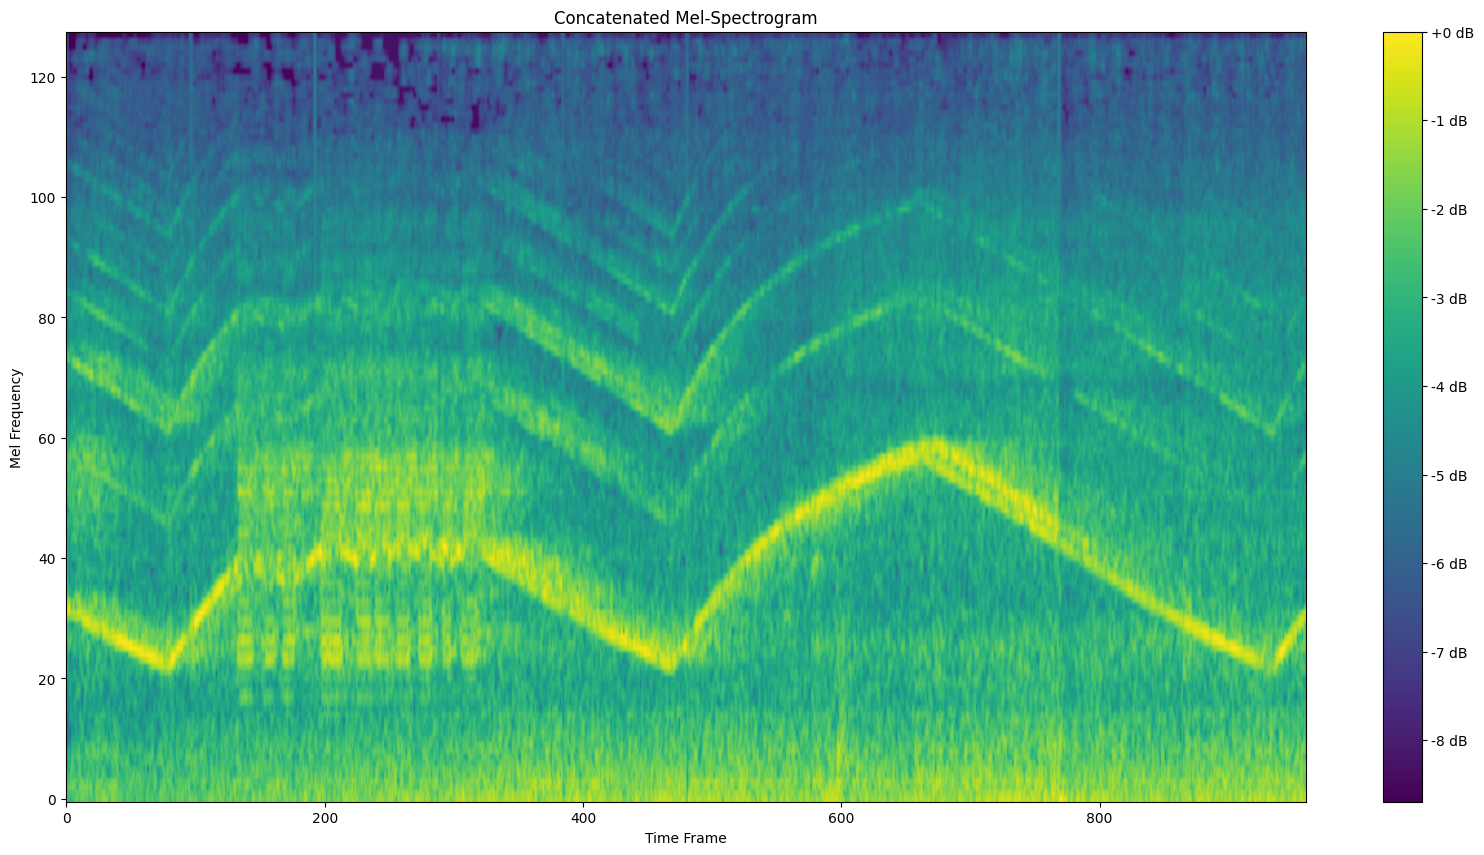

In [24]:
import matplotlib.pyplot as plt
import numpy as np

mel_spectrograms = [np.squeeze(output) for output in model_outputs]

concatenated_spectrogram = np.concatenate(mel_spectrograms, axis=1)

plt.figure(figsize=(20, 10)) 
plt.imshow(concatenated_spectrogram, aspect='auto', origin='lower')
plt.title('Concatenated Mel-Spectrogram')
plt.ylabel('Mel Frequency')
plt.xlabel('Time Frame')
plt.colorbar(format='%+02.0f dB')
plt.show()


### Grad-CAM

In [51]:
import tensorflow as tf
import numpy as np
import cv2
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input

# Grad-CAM 클래스
class GradCAM:
    def __init__(self, model, activation_layer):
        self.model = model
        self.activation_layer = activation_layer
        self.gradient_model = tf.keras.models.Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(activation_layer).output, self.model.output]
        )

    def get_grads(self, input_image):
        with tf.GradientTape() as tape:
            conv_outputs, predictions = self.gradient_model(input_image)
            loss = tf.reduce_max(predictions)  # 가장 높은 예측값에 대한 손실
        grads = tape.gradient(loss, conv_outputs)
        return conv_outputs, grads

    def generate_heatmap(self, input_image, eps=1e-8):
        conv_outputs, grads = self.get_grads(input_image)
        grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        heatmap = tf.reduce_mean(tf.multiply(conv_outputs, grads), axis=-1)
        heatmap = np.maximum(heatmap, 0)
        max_heat = np.max(heatmap)
        if max_heat == 0:
            max_heat = eps
        heatmap /= max_heat
        return heatmap


In [50]:
# 히트맵을 이미지에 적용하는 함수
def apply_heatmap_to_image(heatmap, image, intensity=0.4, colormap=cv2.COLORMAP_JET):
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    superimposed_img = heatmap * intensity + image
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')
    return superimposed_img

In [49]:


# 각 하위 모델에 대한 Grad-CAM 인스턴스 생성
grad_cam_0 = GradCAM(inner_model_0, 'm_main_0_Conv1') # 'target_conv_layer_0'는 첫번째 하위 모델의 대상 층 이름
grad_cam_1 = GradCAM(inner_model_1, 'm_main_1_Conv1') # 'target_conv_layer_1'는 두번째 하위 모델의 대상 층 이름

# 각 하위 모델에 대한 히트맵 생성
heatmap_0 = GradCAM.generate_heatmap(concatenated_spectrogram)
heatmap_1 = GradCAM.generate_heatmap(concatenated_spectrogram)

# 여기서 heatmap_0과 heatmap_1을 적절히 결합하거나 비교할 수 있습니다.
# 예를 들면, 두 히트맵의 평균을 취할 수 있습니다:
combined_heatmap = (heatmap_0 + heatmap_1) / 2

# 원본 이미지에 히트맵 겹치기
superimposed_img_0 = apply_heatmap_to_image(heatmap_0, concatenated_spectrogram)
superimposed_img_1 = apply_heatmap_to_image(heatmap_1, concatenated_spectrogram)

# 두 이미지를 병합
# 이 부분은 두 하위 모델의 결과를 어떻게 결합하고 싶은지에 따라 다릅니다.
# 여기서는 단순히 두 결과 이미지를 옆으로 나란히 보여주는 방법을 사용합니다.
final_image = np.concatenate((superimposed_img_0, superimposed_img_1), axis=1)

# 시각화
cv2.imshow('Grad-CAM Combined', final_image)
cv2.waitKey(0)
cv2.destroyAllWindows()




TypeError: generate_heatmap() missing 1 required positional argument: 'input_image'